# Imports

In [38]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import azureml.core

from datetime import datetime, timedelta
from azureml.core import Dataset
from azureml.opendatasets import NoaaIsdWeather

## Declare variables, read in NOAA ISD data, write to CSV
Using January 2019 weather data as the baseline and June 2019 as the test. Write the data to local csv so that they can be used in Datasets. If you've already registered Datasets with the workspace, you can replace them in the following cells.

In [40]:
# baseline dataset start and end
BASELINE_START = datetime(2019, 1, 1)
BASELINE_END   = datetime(2019, 1, 8)

# test dataset start and end
TEST_INTERVAL  = timedelta(days=7)
TEST_END       = datetime(2019, 7, 25)

# names for writing datasets
local_folder   = 'data-drift-local'
baseline_file  = 'baseline.csv'

# make local dir 
os.makedirs(local_folder, exist_ok=True)

# get baseline dataset
isd_b          = NoaaIsdWeather(BASELINE_START, BASELINE_END)
baseline_df    = isd_b.to_pandas_dataframe()

# write baseline dataframe to local csv
print('writing baseline dataframe to csv...')
baseline_df.to_csv(local_folder + "/" + baseline_file)
print('Done.')

# load baseline dataset
baseline = Dataset.auto_read_files(local_folder + "/" + baseline_file, include_path=True)

test_datasets = {}

i = 0
while BASELINE_END + (i+1)*TEST_INTERVAL < TEST_END:    
    # get test dataset 
    isd_t          = NoaaIsdWeather(BASELINE_END + i*TEST_INTERVAL, BASELINE_END + (i+1)*TEST_INTERVAL)
    test_df        = isd_t.to_pandas_dataframe()
    
    # write test dataframe to local csv
    print('writing test dataframe {} to csv...'.format(i))
    test_df.to_csv(local_folder + "/" + 'test_{}'.format(i))
    print('Done.')
    
    test = Dataset.auto_read_files(local_folder + "/" + 'test_{}'.format(i), include_path=True)
    test_datasets[i] = test
    
    i += 1
    
iters = i

ActivityStarted, to_pandas_dataframe
ActivityStarted, to_pandas_dataframe_in_worker
Target paths: ['/year=2019/month=1/']
Looking for parquet files...
Reading them into Pandas dataframe...
Reading ISDWeather/year=2019/month=1/part-00043-tid-523472863100056975-cc1465d5-7625-4cb5-8e1b-e26830fcb434-1362689.c000.snappy.parquet under container isdweatherdatacontainer
Done.
ActivityCompleted: Activity=to_pandas_dataframe_in_worker, HowEnded=Success, Duration=13266.67 [ms]
ActivityCompleted: Activity=to_pandas_dataframe, HowEnded=Success, Duration=13307.55 [ms]
writing baseline dataframe to csv...
Done.
ActivityStarted, to_pandas_dataframe
ActivityStarted, to_pandas_dataframe_in_worker
Target paths: ['/year=2019/month=1/']
Looking for parquet files...
Reading them into Pandas dataframe...
Reading ISDWeather/year=2019/month=1/part-00043-tid-523472863100056975-cc1465d5-7625-4cb5-8e1b-e26830fcb434-1362689.c000.snappy.parquet under container isdweatherdatacontainer
Done.
ActivityCompleted: Activi

In [41]:
# exclude unneccesary (Path, version, year, day) and columns that clearly drift (datetime)
columns = ['usaf', 'wban', 'latitude', 'longitude', 'elevation', 'windAngle', 'windSpeed', 'temperature', 'seaLvlPressure', 'cloudCoverage', 'presentWeatherIndicator', 'pastWeatherIndicator', 'precipTime', 'precipDepth', 'snowDepth', 'stationName', 'countryOrRegion', 'p_k']

results = {}

for i in test_datasets:
    diff_action = baseline.diff(rhs_dataset=test_datasets[i], columns=columns)
    diff_action.wait_for_completion()
    
    results[i] = diff_action.get_result()

/home/azureuser/.local/lib/python3.6/site-packages/azureml/data/_dataset_diff.py:468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  base[c] = base[c].fillna(value="__null__")
/home/azureuser/.local/lib/python3.6/site-packages/azureml/data/_dataset_diff.py:469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  diff[c] = diff[c].fillna(value="__null__")
/home/azureuser/.local/lib/python3.6/site-packages/azureml/data/_dataset_diff.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

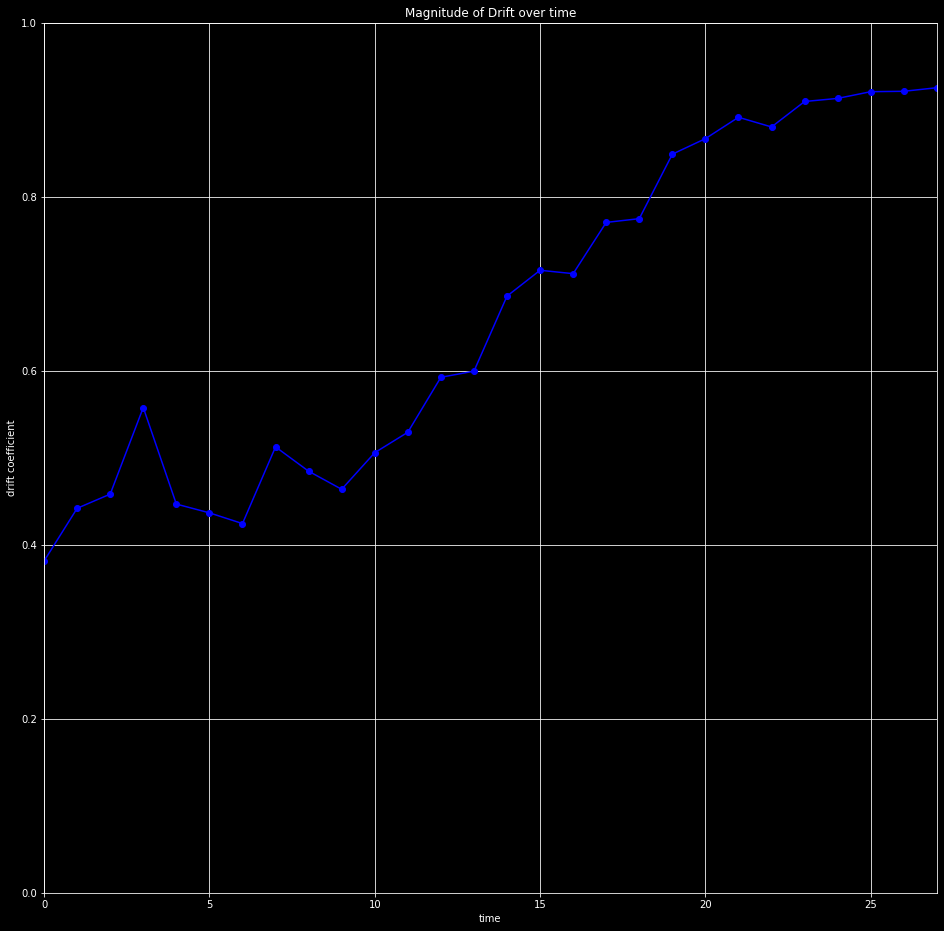

In [44]:
%matplotlib inline

# if using dark mode, uncomment this
plt.style.use(['dark_background'])

fig = plt.figure(figsize=(16, 16))

x = []
y = []

for i in results:
    x.append(i)
    for measurement in results[i]:
        if measurement.name == 'datadrift_coefficient':
            y.append(measurement.value)
        
plt.plot(x, y, 'b-o')
plt.ylabel('drift coefficient')
plt.title('Magnitude of Drift over time')
plt.xlabel('time')
plt.xlim([0, len(x)-1])
plt.ylim([0, 1])
plt.grid()
plt.show()

In [53]:
iters = 28

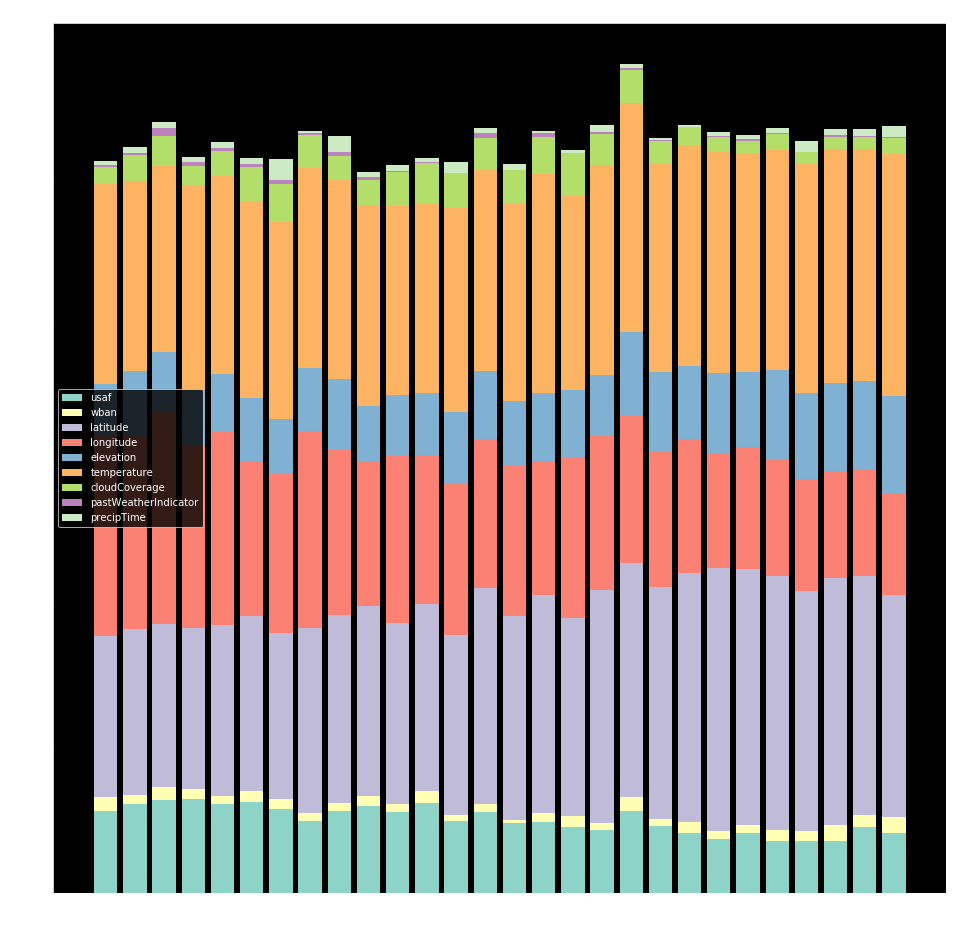

In [59]:
%matplotlib inline

fig = plt.figure(figsize=(16, 16))

x  = []
ys = {column: [] for column in columns}

for i in results:
    x.append(i)
    contribs = []
    total_contrib = 0
    for measurement in results[i]:
        if measurement.name == 'datadrift_contribution':
            contribs.append((measurement.extended_properties['column_name'], measurement.value))
            total_contrib += measurement.value
            
    for column_name, value in contribs:
        ys[column_name].append(value)#/total_contrib*100)

# several features aren't very important in determining drift - let's ignore them
ys = {col: ys[col] for col in ys if len(ys[col]) == len(x)}        

prev = [0]*len(x)
for column in ys:
    plt.bar(x, ys[column], bottom=prev, label=column)
    prev = [prev[i] + ys[column][i] for i in range(len(x))]
        
plt.legend()
plt.xlabel('time')
plt.ylabel('contribution')
plt.title('Contribution by Feature over time')
plt.show()

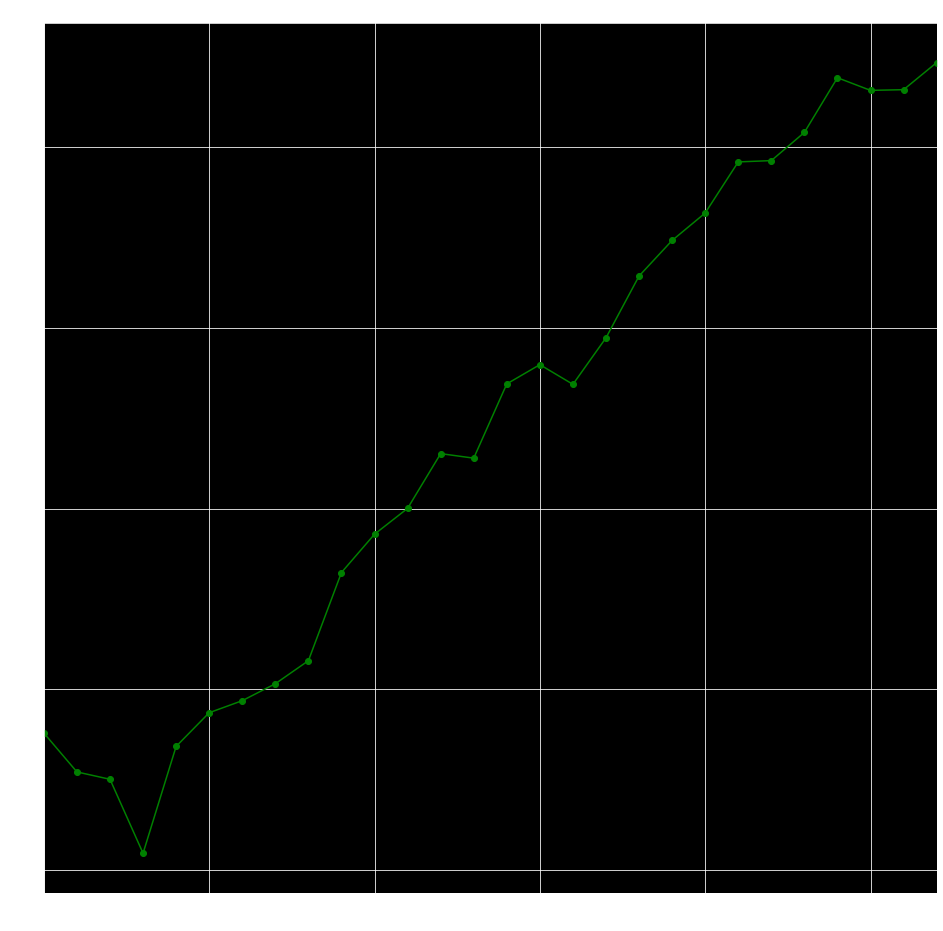

In [75]:
%matplotlib inline

fig = plt.figure(figsize=(16, 16))

y  = []

# drill down into diff measurements and statistical distances for a given column
column_name = 'temperature'
metric_name = 'difference_mean' #'wasserstein_distance'

for result in results:
    for measurement in results[result]:
        if measurement.extended_properties['metric_category'] in ('profile_diff', 'statistical_distance') and measurement.extended_properties['column_name'] == column_name:
            if measurement.name == metric_name:
                y.append(measurement.value)

x = range(len(y))                

plt.plot(x, y, 'g-o')
plt.ylabel(metric_name)
plt.title('{} of {} over time'.format(metric_name, column_name))
plt.xlabel('time')
plt.xlim([0, len(x)-1])
plt.grid()
plt.show()

# Predefine Methods For Result Processing

## Parse and Present Datasets' Diff Results

<font size=2>Each diff result is a list of "DiffMetric" objects. Typically each objec present a detailed measurement output for a specific column.
<br><br>Below is an example of "DiffMetric" object:</font>
<font face="monospace" size=1>
<br>&nbsp;&nbsp;&nbsp;&nbsp;{&nbsp;&nbsp;
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'name':'percentage_difference_median',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;measurement&nbsp;name
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'value':0.01270670472603889,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;the result value a number to indicate how big the diff is for current measurement.
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'extended_properties':{&nbsp;&nbsp;
</font><font face="monospace" size=1 color=LightSteelBlue><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'action_id':'3d3da05d-0871-4cc9-93cb-f43859aae13b',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;action&nbsp;id
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'from_dataset_id':'12edc566-8803-4e0f-ba91-c2ee05eeddee',&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;baseline&nbsp;dataset
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'from_dataset_version':'1',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;baseline&nbsp;version
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'to_dataset_id':'9b85c9ba-50c2-4227-a9bc-91dee4a18228',&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;target&nbsp;dataset
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'to_dataset_version':'1',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;target&nbsp;version
</font><font face="monospace" size=1><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'column_name':'elevation',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;column&nbsp;name&nbsp;in&nbsp;dataset,&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;could&nbsp;be&nbsp;['name':'datadrift_coefficient']&nbsp;for&nbsp;dataset&nbsp;level&nbsp;diff
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'metric_category':'profile_diff'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;category,&nbsp;could&nbsp;be&nbsp;:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;dataset_drift (dataset level)<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;profile_diff (column level)<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;statistical_distance (column level)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;}
<br>&nbsp;&nbsp;&nbsp;&nbsp;}
</font>